<a href="https://colab.research.google.com/github/Ranjankraj/Shala/blob/main/TF2_LoR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import tensorflow as tf

print(tf.__version__)

2.4.0


In [30]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
num_classes = 10  #0 to 9 digits
num_features = 784  #28*28

In [32]:
import numpy as np

#convert data into float as we need W, b in float and originally, they are of int type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

#flatten images to 1D vector of 748 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

#normalize images to [0.0 to 1.0] from [0, 255]
x_train, x_test = x_train/255. , x_test/255.

In [33]:
# logistic regression model equation y = sigmoid(WX + b)
def logistic_regression(X, W, b):
    # apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(tf.add(tf.matmul(X, W), b))

# cross-entropy loss function
def cross_entropy(y_pred, y_true):
    # encode label to a one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)
    # clip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # compute cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), 1))

# accuracy metric
def accuracy(y_pred, y_true):
    # predicted class is the index of highest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [34]:
# Stochastic Gradient Descent optimizer
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# optimization function
def run_optimization(X, y, W, b):
    # wrap computation inside a GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        pred = logistic_regression(X, W, b)
        loss = cross_entropy(pred, y)

    # compute gradients
    gradients = g.gradient(loss, [W, b])

    # update W and b following gradients
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [35]:
# training parameters
batch_size = 256
training_steps = 1000
display_step = 50

# use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# weight of shape [784, 10], the 28*28 image features, and total number of classes.
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# bias of shape [10], the total number of classes.
b = tf.Variable(tf.zeros([num_classes]), name="bias")

# run training for the given number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # run the optimization to update W and b values
    run_optimization(batch_x, batch_y, W, b)

    # display optimization progress every few steps
    if step % display_step == 0:
        pred = logistic_regression(batch_x, W, b)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
    
    # stop with specific accuracy criteria
    #if acc > CONST:
    #    break

step: 50, loss: 1.868433, accuracy: 0.714844
step: 100, loss: 1.572342, accuracy: 0.832031
step: 150, loss: 1.336132, accuracy: 0.816406
step: 200, loss: 1.205417, accuracy: 0.812500
step: 250, loss: 1.120483, accuracy: 0.808594
step: 300, loss: 0.949352, accuracy: 0.832031
step: 350, loss: 0.933055, accuracy: 0.816406
step: 400, loss: 0.840989, accuracy: 0.843750
step: 450, loss: 0.747231, accuracy: 0.890625
step: 500, loss: 0.812020, accuracy: 0.843750
step: 550, loss: 0.720981, accuracy: 0.843750
step: 600, loss: 0.704919, accuracy: 0.867188
step: 650, loss: 0.694608, accuracy: 0.863281
step: 700, loss: 0.629784, accuracy: 0.890625
step: 750, loss: 0.795430, accuracy: 0.835938
step: 800, loss: 0.641923, accuracy: 0.867188
step: 850, loss: 0.657243, accuracy: 0.851562
step: 900, loss: 0.756264, accuracy: 0.828125
step: 950, loss: 0.600320, accuracy: 0.863281
step: 1000, loss: 0.576246, accuracy: 0.871094


In [36]:
# In the above optput, the accuracy improves and then declines because of using SGD as it takes only 1 data point at each epoch
# test model on validation set
pred = logistic_regression(x_test, W, b)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.869000


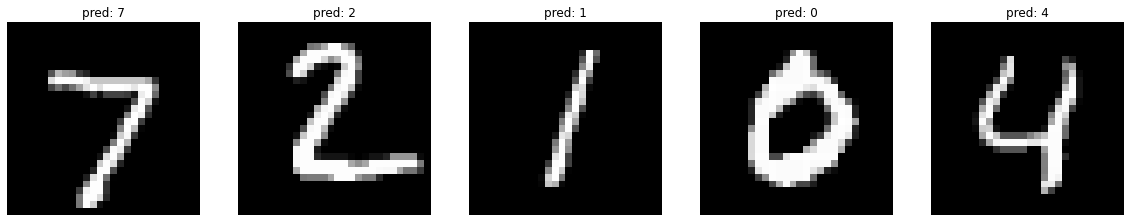

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# set up matplotlib fig, and size it to fit 3x4 pics
nrows = 1
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# predict images from validation set
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images, W, b)

# visualize image and model prediction
for i in range(n_images):
    # set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, title="pred: %i" % np.argmax(predictions.numpy()[i]))
    sp.axis('Off') # don't show axes (or gridlines)
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')

plt.show()